# News clustering - docsim

**INPUT**:

- given corpus of 180K articles

**OUTPUT**:

- indexing by LSI, Doc2Vec: Faster, Sharding, trainable for new documents
- model analytics

**APPLICATIONS**:

- Web interfaces: Text Area for query story --> Clustering: Top Similar Stories (Seeds), Top near-duplicated stories with scores
- Key words search: INPUT text box --> Search all stories related


In [1]:
# import & logging preliminaries
import logging
import itertools

import gensim
from gensim.parsing.preprocessing import STOPWORDS

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
import re 
import string
import unicodedata
import sys

STOPWORDS = [u"ấy", u"bị", u"bởi", u"cả", u"các", u"cái", u"cần", u"càng", u"chỉ", u"chiếc", u"cho", u"chứ", u"chưa", 
             u"chuyện", u"có", u"có_thể", u"cứ", u"của", u"cùng", u"cũng", u"đã", u"đang", u"đây", u"để", u"đến_nỗi", 
             u"đều", u"điều", u"do", u"đó", u"được", u"dưới", u"gì", u"khi", u"không", u"là", u"lại", u"lên", u"lúc", 
             u"mà", u"mỗi", u"một cách", u"này", u"nên", u"nếu", u"ngay", u"nhiều", u"như", u"nhưng", u"những", u"nơi", 
             u"nữa", u"phải", u"qua", u"ra", u"rằng", u"rất", u"rồi", u"sau", u"sẽ", u"so", u"sự", u"tại", u"theo", 
             u"thì", u"trên", u"trước", u"từ", u"từng", u"và", u"vẫn", u"vào", u"vậy", u"vì", u"việc", u"với", u"vừa",
             u"_num", u"wwdateww", u"wwtimeww", u"wwemailww", u"wwipww", u"wwurlww", u"wwnumberww"
            ]

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P') and i != 45 and i!= 95)

def vi_trans_unicode(su):
    return su.translate(tbl)

def vi_strip_text2(s):
    s = re.sub(r"&amp;", "", s)
    s = vi_trans_unicode(s)
    s = re.sub(r"<([^>]+)>", "", s)
    s = re.sub(r"(\s|\\n|\\r|\\t)+", " ", s)
    s = re.sub(r"__+", "_", s)
    s = re.sub(r"--+", "-", s)
    s = re.sub(r'(.)\1+', r'\1\1', s)
    s = ' '.join([w if not w[0].isdigit() else u"wwNUMBERww" for w in s.strip().split()])
    return s


def vi_clean3(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words]
    return ' '.join(words)

def vi_remove_stop_1char(line):
    words = line.split()
    words = [w for w in words if w not in STOPWORDS and len(w) > 1]
    return ' '.join(words)

def vi_clean4(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words if len(w) > 1]
    words = [w for w in words if w not in STOPWORDS]
    return ' '.join(words)

import requests
import codecs
import json

tok_url = "http://192.168.0.215:8081/api/v1.0/document/filter"

def get_tokens(tok_url, data):
    try:
        rq = requests.post(tok_url, data=data.encode('utf-8'))
        if rq.content:
            tok_doc = ' '.join(json.loads(rq.content)['sentences'])
        else:
            tok_doc = None
        return tok_doc
    except Exception, e:
        print e
        

from bs4 import BeautifulSoup

url_post = "http://http://vlsp.vietlp.org:8080/demo/?page=seg_pos_chunk"
header_post = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/4",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
}

def tokenize_soup(soup):
    try:
        sentences = soup.findAll('div', {'class': "sentence"})
        toks = [ s.find('tr').findAll('td')[1:] for s in sentences]
        toks = [t.contents[0] for tok in toks for t in tok]
        return ' '.join(toks)
    except Exception, e:
        print e
        
def get_tokens2(INPUT):
    try:
        payload = {r"input":INPUT}
        rsp = requests.post(url_post, data=payload, headers=header_post)
        soup = BeautifulSoup(rsp.content)
        return tokenize_soup(soup)
    except Exception, e:
        print e

In [ ]:
get_tokens2(u"tìm nhau trong than thở")

## Dictionary, model

In [3]:
from gensim import corpora, models, similarities

In [4]:
# load compact dict
dictionary = corpora.Dictionary.load("/home/laampt/nlp/train/news/lsi/news_180Kdoc.dict")

INFO:gensim.utils:loading Dictionary object from /home/laampt/nlp/train/news/lsi/news_180Kdoc.dict


In [5]:
lsi = models.LsiModel.load("/home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm")

INFO:gensim.utils:loading LsiModel object from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm
INFO:gensim.utils:loading id2word recursively from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm.id2word.* with mmap=None
INFO:gensim.utils:setting ignored attribute projection to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:loading LsiModel object from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm.projection
INFO:gensim.utils:loading u from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm.projection.u.npy with mmap=None


In [6]:
print lsi

LsiModel(num_terms=392517, num_topics=200, decay=1.0, chunksize=20000)


## Sim index

In [7]:
from gensim.similarities.docsim import Similarity

In [8]:
index_lsi = Similarity.load('/home/laampt/nlp/train/news/lsi/news_180Kdoc_lsi.index')

INFO:gensim.utils:loading Similarity object from /home/laampt/nlp/train/news/lsi/news_180Kdoc_lsi.index


In [9]:
print index_lsi

Similarity index with 189288 documents in 6 shards (stored under shard)


## Doc2vec

In [10]:
import numpy as np  
from gensim.models import Doc2Vec

In [11]:
dmm = Doc2Vec.load("/home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100")
print dmm

INFO:gensim.utils:loading Doc2Vec object from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100
INFO:gensim.utils:loading docvecs recursively from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.syn1neg.npy with mmap=None
INFO:gensim.utils:loading syn0 from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.syn0.npy with mmap=None
INFO:gensim.uti

Doc2Vec(dm/m,d200,n5,w5,mc2,s1e-05,t8)


In [12]:
print dmm.docvecs.doctag_syn0[1][:10]
print dmm.docvecs[1][:10]

[ 0.11819465  0.02252917 -0.05527491 -0.00620151 -0.05047297  0.14769495
  0.20530233  0.1566548   0.17334339 -0.16159682]
[ 0.11819465  0.02252917 -0.05527491 -0.00620151 -0.05047297  0.14769495
  0.20530233  0.1566548   0.17334339 -0.16159682]


In [13]:
print "Num of docs: ", dmm.docvecs.count
print dmm.docvecs.n_similarity(['SENT_vt_1', 'SENT_vt_2'], ['SENT_vt_100', 'SENT_vt_200'])
dmm.docvecs.trained_item?

Num of docs:  189288
0.61904731227


## Sanity check

In [71]:
def get_lsi_index(lsi, dictionary, index_lsi, new_doc, topn=20):
    new_doc = vi_clean4(vi_strip_text2(new_doc))
    new_vec = dictionary.doc2bow(new_doc.split())
    new_vec_ls = lsi[new_vec]
    index_lsi.num_best = topn
    return index_lsi[new_vec_ls]

In [14]:
# new_doc = u"""tình_hình nhà_mạng vnpt viettel mobifone áp_dụng chính_sách chuyển mạng giữ nguyên số"""
new_doc = u"""Đến nay, Viettel đang thực_hiện đúng lộ_trình thoái vốn mà Thủ_tướng yêu_cầu."""
new_doc = vi_clean4(vi_strip_text2(new_doc))
new_vec = dictionary.doc2bow(new_doc.split())
new_vec_ls = lsi[new_vec]

index_lsi.num_best = 20
related_story_lsi = index_lsi[new_vec_ls]
print related_story_lsi

INFO:gensim.utils:loading SparseMatrixSimilarity object from shard.0
INFO:gensim.utils:loading SparseMatrixSimilarity object from shard.1
INFO:gensim.utils:loading SparseMatrixSimilarity object from shard.2
INFO:gensim.utils:loading SparseMatrixSimilarity object from shard.3
INFO:gensim.utils:loading SparseMatrixSimilarity object from shard.4
INFO:gensim.utils:loading SparseMatrixSimilarity object from shard.5


[(2634, 0.68815743923187256), (13847, 0.68097615242004395), (10904, 0.67659056186676025), (136023, 0.6505778431892395), (118434, 0.64575409889221191), (156469, 0.64530295133590698), (11298, 0.64130252599716187), (55261, 0.63939350843429565), (32957, 0.62919384241104126), (110295, 0.62907785177230835), (37902, 0.62767887115478516), (15176, 0.62761944532394409), (46096, 0.62665653228759766), (125402, 0.62637197971343994), (166477, 0.61827117204666138), (122490, 0.61673116683959961), (43713, 0.61531752347946167), (168015, 0.61521947383880615), (130368, 0.6112787127494812), (159694, 0.61031955480575562)]


In [15]:
new_doc = u"""Đến nay, Viettel đang thực_hiện đúng lộ_trình thoái vốn mà Thủ_tướng yêu_cầu."""
new_doc = vi_clean4(vi_strip_text2(new_doc))
print new_doc
related_story_d2v = []

pos_terms = []
for w in new_doc.split():
    pos_terms.append(dmm[w])

wvec = dmm.infer_vector(new_doc.split())
related_story_d2v = dmm.docvecs.most_similar(positive=pos_terms)
print related_story_d2v

INFO:gensim.models.doc2vec:precomputing L2-norms of doc weight vectors


đến nay viettel thực_hiện đúng lộ_trình thoái vốn thủ_tướng yêu_cầu
[(u'SENT_vt_61897', 0.34041744470596313), (u'SENT_vt_97151', 0.34023094177246094), (u'SENT_vt_165543', 0.3342686891555786), (u'SENT_vt_64938', 0.329241544008255), (u'SENT_vt_25220', 0.3268060088157654), (u'SENT_vt_77662', 0.3258041441440582), (u'SENT_vt_134548', 0.3249977231025696), (u'SENT_vt_188529', 0.3120863437652588), (u'SENT_vt_173718', 0.30741631984710693), (u'SENT_vt_149251', 0.30578574538230896)]


## Query

In [16]:
from collections import defaultdict

In [17]:
print new_doc
print '.' * 80
print "[*] Getting seed stories ..."
seeds = []
for s,v in dmm.docvecs.most_similar(positive=pos_terms, topn=20):
    if v > 0.3: seeds.append(s)

seeds = list(set(seeds))

print "[*] Getting depth stories ..."
story_clusters = defaultdict(list)
try:
    seen_seeds = [] # keep seen seends to collapse all near duplicated seeds
    for seed in seeds:
        if seen_seeds:
            max_sim = np.max([dmm.docvecs.similarity(seed,seen) for seen in seen_seeds])
            if max_sim > 0.9:
                continue
                print "PASSED: ", seed
        seen_seeds.append(seed)
        related_stories = [(s,v) for s,v in dmm.docvecs.most_similar([dmm.docvecs[seed]], topn=100) if (v > 0.8) and s != seed]
        story_clusters[seed] = related_stories
        
except Exception, e:
    print e

print len(seeds), len(seen_seeds)

print "NUM SEEDS: {}".format(len(seen_seeds))
print '.' * 80
for seed in seen_seeds:
    related_stories = story_clusters[seed]
    print seed, len(related_stories)
    for story,v in related_stories:
        print "--{}: {}".format(story,v)
    print
    
line_d2v_idx = [int(s.split('_')[-1]) for s in seen_seeds]

đến nay viettel thực_hiện đúng lộ_trình thoái vốn thủ_tướng yêu_cầu
................................................................................
[*] Getting seed stories ...
[*] Getting depth stories ...
19 13
NUM SEEDS: 13
................................................................................
SENT_vt_141747 2
--SENT_vt_134548: 0.935555994511
--SENT_vt_165543: 0.916878759861

SENT_vt_77662 0

SENT_vt_149251 2
--SENT_vt_186162: 0.929334998131
--SENT_vt_92904: 0.889158308506

SENT_vt_188529 1
--SENT_vt_97151: 0.937943816185

SENT_vt_92904 2
--SENT_vt_149251: 0.889158308506
--SENT_vt_186162: 0.886856138706

SENT_vt_25220 0

SENT_vt_137349 7
--SENT_vt_172548: 0.96997231245
--SENT_vt_171865: 0.964117825031
--SENT_vt_65424: 0.963232815266
--SENT_vt_138471: 0.962852120399
--SENT_vt_120381: 0.960778415203
--SENT_vt_138476: 0.954799890518
--SENT_vt_83234: 0.931590437889

SENT_vt_61897 2
--SENT_vt_184361: 0.913268923759
--SENT_vt_110788: 0.903998613358

SENT_vt_173718 0

SENT_vt_11

In [18]:
print new_doc
wvec = dmm.infer_vector(new_doc.split())
print '.' * 80
print "[*] Getting seed stories ..."
seeds = []
for s,v in dmm.docvecs.most_similar(positive=[wvec], topn=100):
    if v > 0.3: seeds.append(s)

seeds = list(set(seeds))

print "[*] Getting depth stories ..."
story_clusters = defaultdict(list)
try:
    seen_seeds = [] # keep seen seends to collapse all near duplicated seeds
    for seed in seeds:
        if seen_seeds:
            max_sim = np.max([dmm.docvecs.similarity(seed,seen) for seen in seen_seeds])
            if max_sim > 0.9:
                continue
                print "PASSED: ", seed
        seen_seeds.append(seed)
        related_stories = [(s,v) for s,v in dmm.docvecs.most_similar([dmm.docvecs[seed]], topn=100) if (v > 0.8) and s != seed]
        story_clusters[seed] = related_stories
        
except Exception, e:
    print e

print len(seeds), len(seen_seeds)

print "NUM SEEDS: {}".format(len(seen_seeds))
print '.' * 80
for seed in seen_seeds:
    related_stories = story_clusters[seed]
    print seed, len(related_stories)
    for story,v in related_stories:
        print "--{}: {}".format(story,v)
    print

đến nay viettel thực_hiện đúng lộ_trình thoái vốn thủ_tướng yêu_cầu
................................................................................
[*] Getting seed stories ...
[*] Getting depth stories ...
100 27
NUM SEEDS: 27
................................................................................
SENT_vt_185312 99
--SENT_vt_48448: 0.947994351387
--SENT_vt_121423: 0.939591825008
--SENT_vt_50502: 0.938539326191
--SENT_vt_126943: 0.937654197216
--SENT_vt_27981: 0.936746954918
--SENT_vt_107079: 0.935621857643
--SENT_vt_5885: 0.934432148933
--SENT_vt_91671: 0.934156596661
--SENT_vt_108210: 0.933963060379
--SENT_vt_127089: 0.933781445026
--SENT_vt_613: 0.932244837284
--SENT_vt_4776: 0.932178854942
--SENT_vt_91646: 0.931899428368
--SENT_vt_145273: 0.931514203548
--SENT_vt_22934: 0.930208444595
--SENT_vt_26268: 0.930148243904
--SENT_vt_38127: 0.930031776428
--SENT_vt_6516: 0.929393708706
--SENT_vt_144989: 0.929265022278
--SENT_vt_57465: 0.928655683994
--SENT_vt_37074: 0.92864125967

In [ ]:
print seeds
print
print seen_seeds

In [74]:
d1 = 'SENT_vt_141747'
d2 = 'SENT_vt_134548'

idx = [141747, 134548]

test_docs = []
with codecs.open("/home/laampt/nlp/data/news/tok/vt.261K.casen.txt.10word.nodup.clean.nodup", encoding="utf-8", mode='r') as fin:
    for i, line in enumerate(fin):
        if i in idx:
            test_docs.append(line)

ls1 = test_docs[0]
ls2 = test_docs[1]

ls1_sim = get_lsi_index(lsi, dictionary, index_lsi, ls1, topn=20)
ls2_sim = get_lsi_index(lsi, dictionary, index_lsi, ls2, topn=20)

print "DISTANCE LSI vs DMM"
print '-'* 80
print 'Doc ', d1
print ls1
print 'Doc ', d2
print ls2
print '-' * 80
print "DMM SIM ", dmm.docvecs.similarity(d1,d2)
print "LSI SIM ", ls1_sim


DISTANCE LSI vs DMM
--------------------------------------------------------------------------------
Doc  SENT_vt_141747
siêu_thị nệm liên một trong dịch_vụ sản_phẩm chính khải_hoàn liên_hệ chúng_tôi tư_vấn tốt nhất quả_đấm_thép thép gỉ quả_đấm_thép thép gỉ tiến_trình tái_cơ_cấu vốn_đầu_tư khu_vực doanh_nghiệp nhà_nước dnnn thông_qua hoạt_động thoái_vốn hay cổ_phần_hóa diễn_ra chậm_chạp tác_động tiêu_cực tới tiến_trình tái_cơ_cấu chung nền_kinh_tế đòi_hỏi có_một hành_động cương_quyết cứng_rắn thực_tế hoạt_động dnnn thời_gian chứng_minh hiệu_quả quả_đấm_thép mang nền_kinh_tế còn thấp tương_xứng nguồn_lực ưu_đãi báo_cáo bộ_tài_chính vốn_chủ_sở_hữu tập_đoàn kinh_tế tổng_công_ty trong tăng doanh_thu_tăng nộp_ngân_sách tăng khoảng trừ đi tốc_độ tăng giá_tiêu_dùng vốn_chủ_sở_hữu đóng_góp ngân_sách quả_đấm_thép giảm báo_cáo tỷ_suất lợi_nhuận vốn_chủ_sở_hữu tập_đoàn tổng_công_ty thấp hơn lãi_vay ngân_hàng lợi_nhuận trước_thuế tăng chủ_yếu rơi một_số đơn_vị trong số petrovietnam đạt tỷ đồng vie

## Bulk training check on 1000 docs

In [19]:
rand_idx = np.random.randint(0,180000, 1000)
print len(rand_idx)

1000


In [20]:
test_docs = []
with codecs.open("/home/laampt/nlp/data/news/tok/vt.261K.casen.txt.10word.nodup.clean.nodup", encoding="utf-8", mode='r') as fin:
    for i, line in enumerate(fin):
        if i in rand_idx:
            test_docs.append((i,line))

In [21]:
def get_vec(dmm,doc):
    vec_sum = np.zeros((1,200))
    words = set(doc.split())
    for word in words:
        if word in dmm.vocab:
            vec_sum += dmm[word]
    return vec_sum[0]

In [23]:
slice_tups = []
slice_docs = []
index_lsi.num_best = dmm.docvecs.count

count = 0
for true_id, doc in test_docs:
    if count % 100 == 0: print "[*] PROGRESS at: ", count
    count += 1
    
    doc = doc.split()
    slice_doc = doc[np.random.randint(len(doc)-5):][:1000] # get random index from right 12 words, max 1000 words
    slice_docs.append(slice_doc)
    slice_inferred = dmm.infer_vector(slice_doc)
    slice_noinferred = get_vec(dmm, ' '.join(slice_doc))
    new_vec = dictionary.doc2bow(slice_doc)
    new_vec_ls = lsi[new_vec]
    
    
    similars = dmm.docvecs.most_similar(positive=[slice_inferred],topn=dmm.docvecs.count)
    similars2 = dmm.docvecs.most_similar(positive=[slice_noinferred],topn=dmm.docvecs.count)
    similars3 = index_lsi[new_vec_ls]
    
    rank_of_source = [int(sim_id.split('_')[-1]) for sim_id, sim in similars].index(true_id)
    rank_of_source2 = [int(sim_id.split('_')[-1]) for sim_id, sim in similars2].index(true_id)
    rank_of_source3 = [int(sim_id) for sim_id, sim in similars3].index(true_id)
    
    slice_tups.append((true_id, len(slice_doc), rank_of_source, rank_of_source2, rank_of_source3))

[*] PROGRESS at:  0
[*] PROGRESS at:  100
[*] PROGRESS at:  200
[*] PROGRESS at:  300
[*] PROGRESS at:  400
[*] PROGRESS at:  500
[*] PROGRESS at:  600
[*] PROGRESS at:  700
[*] PROGRESS at:  800
[*] PROGRESS at:  900


In [24]:
with codecs.open("/home/laampt/nlp/data/news/tok/vt.random_1Kdocs_1Kwords.nodup", encoding="utf-8", mode='w') as fout:
    for doc in slice_docs:
        fout.write(' '.join(doc) + '\n')

## Analyse result

We done following steps:

- Random 1000 docs with length max 1000 words
- Generate sim matrix in both LSI, DMM
- Rank with LSI, DMM by checking index of original ID
- Check whether DMM getting better in comparison to LSI when having longer text

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

In [26]:
df = pd.DataFrame(slice_tups, columns=['DocID', 'Len', 'DMM', 'SUM', 'LSI'])

In [28]:
df.set_index('DocID', inplace=True)

In [29]:
df.head()

,Len,DMM,SUM,LSI
DocID,,,,
100,107,9,63747,0
345,263,1,12,1
457,30,10210,591,9
512,73,14792,13189,847
629,549,0,137,1


In [30]:
df.describe()

,Len,DMM,SUM,LSI
count,998.000000,998.000000,998.000000,998.000000
mean,180.215431,3918.915832,4317.573146,569.941884
std,181.635246,15531.494284,14871.779096,4912.899685
min,6.000000,0.000000,0.000000,0.000000
25%,56.000000,0.000000,57.000000,0.000000
50%,121.500000,2.000000,300.000000,1.000000
75%,246.750000,79.000000,1662.250000,7.000000
max,1000.000000,188094.000000,157040.000000,95228.000000


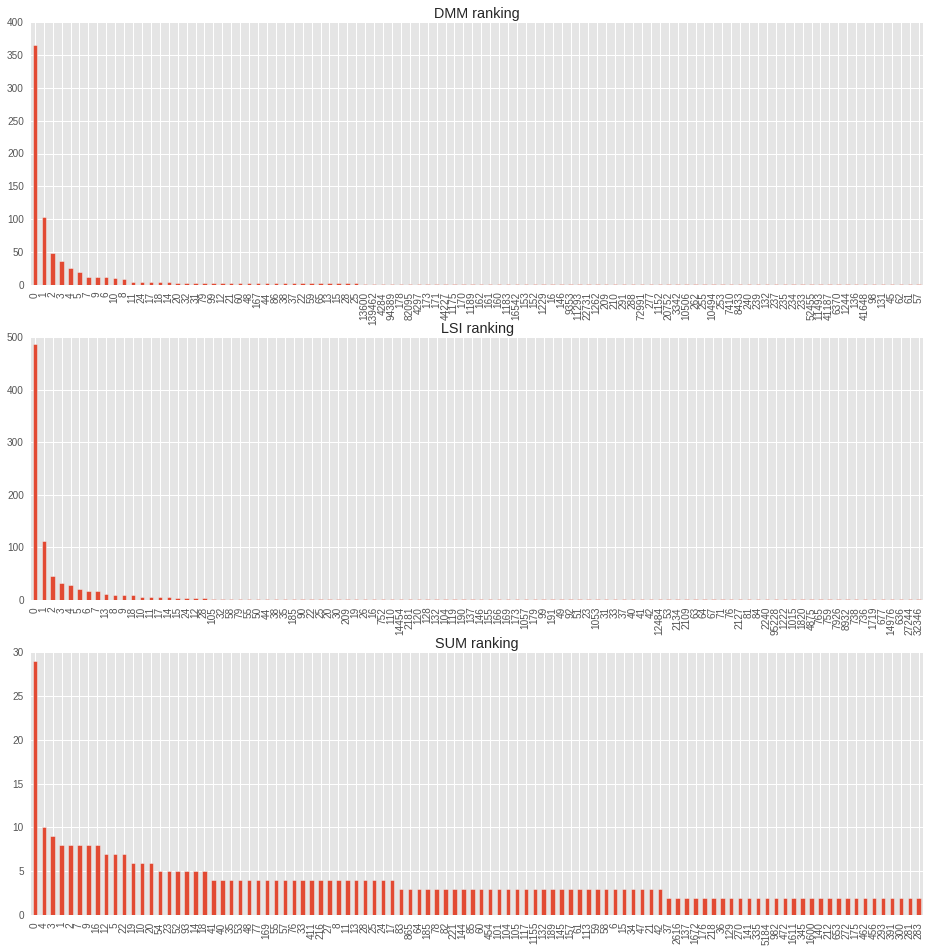

In [31]:
%matplotlib inline 

plt.figure(figsize=(16,16))
plt.subplot(311)
ax1 = df['DMM'].value_counts().head(100).plot(kind='bar', label='DMM')
ax1.set_title("DMM ranking")
plt.subplot(312)
ax2 = df.LSI.value_counts().head(100).plot(kind='bar', label='LSI')
ax2.set_title("LSI ranking")

plt.subplot(313)
ax3 = df.SUM.value_counts().head(100).plot(kind='bar', label='SUM')
ax3.set_title("SUM ranking")
plt.show()

In [32]:
dlm = df.groupby(by=['DMM', 'LSI']).agg({'Len': pd.Series.count})
dlm.rename(columns={'Len': 'Occurrences'}, inplace=True)
dlm.head()

Occurrences
DMM LSI             
0   0            294
    1             30
    2              9
    3              5
    4              4

In [33]:
dlm.reset_index(inplace=True)
dlm.head()

,DMM,LSI,Occurrences
0,0,0,294
1,0,1,30
2,0,2,9
3,0,3,5
4,0,4,4


In [34]:
dlm_pivot = dlm.pivot('DMM', 'LSI', 'Occurrences')
dlm_pivot.fillna(0, inplace=True)
dlm_pivot.head()

LSI,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,28,29,30,31,32,33,35,37,38,40,41,42,44,49,50,51,53,55,58,63,64,67,71,76,79,81,84,86,90,92,99,104,105,110,119,120,128,132,137,146,155,166,169,173,179,185,190,191,204,209,220,236,240,257,267,269,271,287,304,340,343,344,358,369,389,415,420,429,433,440,444,505,537,564,636,677,736,738,752,759,765,811,820,821,829,847,900,913,917,950,975,1015,1053,1057,1062,1222,1228,1234,1275,1423,1495,1531,1719,1820,2030,2109,2127,2134,2181,2240,2259,3001,3333,3491,4206,4324,4682,4875,4896,7117,7582,7704,7926,8932,9013,9150,9582,10228,12484,14454,14976,18783,27244,32346,45989,49709,84391,95228
DMM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,294,30,9,5,4,5,2,1,1,0,1,0,0,2,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,47,29,3,5,3,5,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12,13,8,3,0,1,4,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,6,3,3,6,3,1,2,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3,4,4,3,1,0,1,0,0,0,0,0,1,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


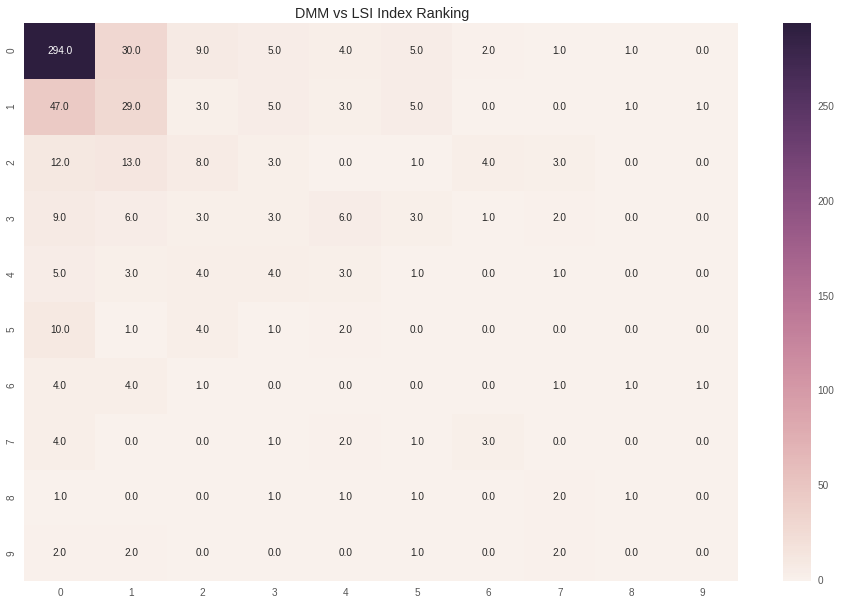

In [35]:
slice_noinferred = get_vec(dmm, ' '.join(slice_doc))
new_vec = dictionary.doc2bow(slice_doc)
new_vec_ls = lsi[new_vec]
plt.figure(figsize=(16, 10))
plt.title('DMM vs LSI Index Ranking')
sns.heatmap(dlm_pivot.as_matrix()[:10,:10], annot=True, fmt='')
plt.show()

In [ ]:
slice_noinferred = get_vec(dmm, ' '.join(slice_doc))
new_vec = dictionary.doc2bow(slice_doc)
new_vec_ls = lsi[new_vec]plt.figure(figsize=(16, 10))
plt.title('DMM vs LSI Index Ranking')
sns.heatmap(dlm_pivot.as_matrix()[:10,:10], annot=True, fmt='')
plt.show()

In [36]:
# new_doc = ' '.join(slice_docs[200])
new_doc = u"Được biết Viettel đã và đang tăng nhanh vùng phủ_sóng G tới hơn diện_tích tỉnh thành_phố trong năm Nhiều ưu_đãi cho người dùng USB G của Viettel Tôi Viết TNO Từ ngày đến hết ngày người_dùng khi đăng_ký sử_dụng dịch_vụ USB G của Viettel sẽ được hưởng nhiều chính_sách ưu_đãi Để biết thêm thông_tin chi_tiết bạn_đọc có thể tham_khảo thêm tại website g vietteltele Nếu người_dùng mua USB G và hòa_mạng trả trước sẽ được tặng MB lưu_lượng sử_dụng kể từ tháng thứ phải kích_hoạt liên_tục trong tháng Cụ thể người_dùng khi mua USB G giá đồng và sử_dụng dịch_vụ hòa_mạng trả sau sẽ được miễn phí hòa_mạng trị_giá đồng tặng đồng cước sử_dụng bao_gồm cước thuê_bao và cước lưu_lượng số tiền này được giảm trừ đồng tháng vào cước sử_dụng trong tháng liên_tiếp kể từ tháng liền kề tháng hòa mạng."
print new_doc

Được biết Viettel đã và đang tăng nhanh vùng phủ_sóng G tới hơn diện_tích tỉnh thành_phố trong năm Nhiều ưu_đãi cho người dùng USB G của Viettel Tôi Viết TNO Từ ngày đến hết ngày người_dùng khi đăng_ký sử_dụng dịch_vụ USB G của Viettel sẽ được hưởng nhiều chính_sách ưu_đãi Để biết thêm thông_tin chi_tiết bạn_đọc có thể tham_khảo thêm tại website g vietteltele Nếu người_dùng mua USB G và hòa_mạng trả trước sẽ được tặng MB lưu_lượng sử_dụng kể từ tháng thứ phải kích_hoạt liên_tục trong tháng Cụ thể người_dùng khi mua USB G giá đồng và sử_dụng dịch_vụ hòa_mạng trả sau sẽ được miễn phí hòa_mạng trị_giá đồng tặng đồng cước sử_dụng bao_gồm cước thuê_bao và cước lưu_lượng số tiền này được giảm trừ đồng tháng vào cước sử_dụng trong tháng liên_tiếp kể từ tháng liền kề tháng hòa mạng.


In [37]:
slice_inferred = dmm.infer_vector(slice_doc)
new_vec = dictionary.doc2bow(slice_doc)
new_vec_ls = lsi[new_vec]

In [40]:
print sorted(new_vec_ls, key=lambda x: x[1], reverse=True)[:10]
print 
print lsi.print_topic(1, topn=20)
print
print lsi.print_topic(0, topn=20)
print
print lsi.print_topic(56, topn=20)

[(1, 1.106783117823616), (0, 0.67449728074564963), (56, 0.50819350996232482), (84, 0.49447101296422441), (93, 0.48958348352573405), (72, 0.46221844339763607), (73, 0.45646006397048483), (109, 0.42782853706278307), (44, 0.34559761738919731), (127, 0.33975079346993159)]

0.271*"em" + 0.253*"mình" + 0.250*"bạn" + -0.205*"công_ty" + -0.175*"doanh_nghiệp" + 0.170*"thảo_luận" + 0.158*"anh" + 0.155*"tôi" + 0.152*"nó" + 0.144*"người" + 0.136*"bác" + 0.126*"nói" + -0.121*"dịch_vụ" + 0.119*"một" + -0.116*"phát_triển" + -0.114*"hoạt_động" + 0.113*"nào" + 0.110*"ko" + -0.107*"trong" + 0.106*"còn"

0.415*"trong" + 0.241*"một" + 0.229*"về" + 0.187*"đến" + 0.162*"việt_nam" + 0.156*"công_ty" + 0.150*"doanh_nghiệp" + 0.146*"dịch_vụ" + 0.137*"người" + 0.136*"thể" + 0.126*"khách_hàng" + 0.118*"còn" + 0.116*"viettel" + 0.111*"hơn" + 0.099*"thị_trường" + 0.098*"phát_triển" + 0.095*"hoạt_động" + 0.095*"mình" + 0.094*"sản_phẩm" + 0.092*"mới"

0.241*"máy" + -0.231*"tỉnh" + 0.229*"chị" + -0.216*"viễn_thông" + 

In [41]:
topics = [1,0,56]
keywords = defaultdict(int)
for topic in topics:
    for v, k in sorted(lsi.show_topic(topic, topn=20), key=lambda x: x[0], reverse=True):
        keywords[k] += v

In [42]:
keywords_sorted = sorted(keywords.iteritems(),key=lambda x: x[1], reverse=True)
for k,v in keywords_sorted:
    print k, v

một 0.35950971962
trong 0.308140112129
người 0.281179105358
mới 0.273208561509
em 0.270885504055
mình 0.252031906264
bạn 0.249565189119
máy 0.240769024612
chị 0.229305772755
về 0.22880150793
còn 0.224299382702
công_nghệ 0.189831705183
đến 0.187287408415
hà_nội 0.177659348623
tổ_chức 0.173481518686
thảo_luận 0.170434749632
việt_nam 0.161721027582
anh 0.157978813803
tôi 0.154543707697
nó 0.152438251042
tt 0.140521551651
thể 0.136436747249
bác 0.13600512486
khách_hàng 0.126399780449
nói 0.126230160243
viettel 0.116238177955
nào 0.11337477723
hơn 0.111424654983
ko 0.110467006942
quảng_cáo 0.104739870083
thị_trường 0.0986109404525
dn 0.0943791379255
hoạt_động 0.0880860964996
dịch_vụ 0.0248679217659
phát_triển -0.0181414072845
doanh_nghiệp -0.0257344680553
sản_phẩm -0.0410081965231
công_ty -0.048746905639
sử_dụng -0.0956884096901
sim -0.0963726500329
huyện -0.103260582889
chúng_tôi -0.116155172619
cntt -0.166957849218
sinh_viên -0.197235437437
viễn_thông -0.215718231115
tỉnh -0.230835434286


In [43]:
for k, v in dmm.docvecs.most_similar([slice_inferred]):
    print k,v

SENT_vt_107507 0.758140146732
SENT_vt_108666 0.735443532467
SENT_vt_9234 0.73213738203
SENT_vt_59034 0.729073643684
SENT_vt_100675 0.724598884583
SENT_vt_176052 0.724367141724
SENT_vt_136011 0.719925284386
SENT_vt_73822 0.718918323517
SENT_vt_187102 0.718122184277
SENT_vt_108992 0.717890977859


In [44]:
df["Doc"] = [' '.join(doc) for doc in slice_docs]

In [45]:
df.head()

,Len,DMM,SUM,LSI,Doc
DocID,,,,,
100,107,9,63747,0,công_nghệ cung_cấp nhân_lực cung_cấp dịch_vụ c...
345,263,1,12,1,trong_suốt thời_gian các_bạn_học tập giảng_đườ...
457,30,10210,591,9,tốt vượt khó đạt kết_quả cao_hơn trong học_tập...
512,73,14792,13189,847,nguyễn_quốc_tuấn hagl các_cầu thủ thủ_môn nguy...
629,549,0,137,1,chẳng muốn chết thảo_luận em biết gprs vịtteo ...


In [46]:
# df.to_json("/home/laampt/nlp/data/news/vt_1Kdocs_1Kwords_random_pd.json")
# df = pd.read_json("/home/laampt/nlp/data/news/vt_1Kdocs_random_pd.json")

In [47]:
df = df[['Doc', 'Len', 'DMM', 'LSI', 'SUM']]
df.head()

,Doc,Len,DMM,LSI,SUM
DocID,,,,,
100,công_nghệ cung_cấp nhân_lực cung_cấp dịch_vụ c...,107,9,0,63747
345,trong_suốt thời_gian các_bạn_học tập giảng_đườ...,263,1,1,12
457,tốt vượt khó đạt kết_quả cao_hơn trong học_tập...,30,10210,9,591
512,nguyễn_quốc_tuấn hagl các_cầu thủ thủ_môn nguy...,73,14792,847,13189
629,chẳng muốn chết thảo_luận em biết gprs vịtteo ...,549,0,1,137


In [48]:
df.describe()

,Len,DMM,LSI,SUM
count,998.000000,998.000000,998.000000,998.000000
mean,180.215431,3918.915832,569.941884,4317.573146
std,181.635246,15531.494284,4912.899685,14871.779096
min,6.000000,0.000000,0.000000,0.000000
25%,56.000000,0.000000,0.000000,57.000000
50%,121.500000,2.000000,1.000000,300.000000
75%,246.750000,79.000000,7.000000,1662.250000
max,1000.000000,188094.000000,95228.000000,157040.000000


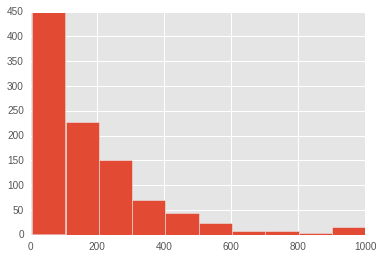

In [49]:
%matplotlib inline 

df.Len.hist()

In [50]:
df[df.Len >= 200].describe()

,Len,DMM,LSI,SUM
count,324.000000,324.000000,324.000000,324.000000
mean,382.179012,6.935185,2.179012,3514.385802
std,189.149847,31.286435,5.426006,14209.067259
min,202.000000,0.000000,0.000000,0.000000
25%,253.500000,0.000000,0.000000,51.000000
50%,314.000000,0.000000,0.000000,220.000000
75%,445.000000,3.000000,1.000000,911.500000
max,1000.000000,353.000000,50.000000,153325.000000


In [53]:
df[df.Len >= 500].describe()

,Len,DMM,LSI,SUM
count,58.000000,58.000000,58.000000,58.000000
mean,717.586207,5.310345,2.689655,5631.913793
std,181.545706,15.673429,6.227294,22938.964894
min,501.000000,0.000000,0.000000,0.000000
25%,555.250000,0.000000,0.000000,20.250000
50%,666.000000,0.000000,0.000000,77.500000
75%,894.750000,2.750000,2.000000,420.250000
max,1000.000000,86.000000,31.000000,153325.000000


In [54]:
df[df.Len >= df.Len.max()].describe()

,Len,DMM,LSI,SUM
count,10,10.000000,10.000000,10.000000
mean,1000,1.000000,0.500000,59.200000
std,0,1.885618,0.849837,118.486567
min,1000,0.000000,0.000000,0.000000
25%,1000,0.000000,0.000000,8.750000
50%,1000,0.000000,0.000000,15.000000
75%,1000,0.750000,0.750000,51.000000
max,1000,5.000000,2.000000,391.000000


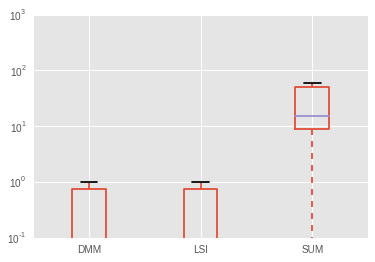

In [55]:
df2 = df[df.Len >= df.Len.max()][['DMM', 'LSI', 'SUM']]
df2.plot(kind='box', logy=True)

## How to rank: MRR

In [58]:
def get_mrr(ds,ls):
    return [0.5 * (1.0/(d+1.0) + 1.0/(l+1.0)) for d,l in zip(ds,ls)]

In [59]:
df['MegaRank'] = get_mrr(df.DMM.values, df.LSI.values)

In [70]:
df.head()

,Doc,Len,DMM,LSI,SUM,MegaRank
DocID,,,,,,
100,công_nghệ cung_cấp nhân_lực cung_cấp dịch_vụ c...,107,9,0,63747,0.550000
345,trong_suốt thời_gian các_bạn_học tập giảng_đườ...,263,1,1,12,0.500000
457,tốt vượt khó đạt kết_quả cao_hơn trong học_tập...,30,10210,9,591,0.050049
512,nguyễn_quốc_tuấn hagl các_cầu thủ thủ_môn nguy...,73,14792,847,13189,0.000623
629,chẳng muốn chết thảo_luận em biết gprs vịtteo ...,549,0,1,137,0.750000


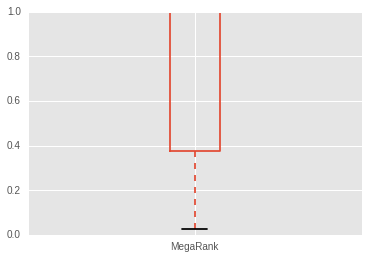

In [67]:
df[df.Len >=500][['MegaRank']].plot(kind='box', logy=False)

In [69]:
df[df.Len >=200][['MegaRank']].describe()

,MegaRank
count,324.000000
mean,0.688496
std,0.336178
min,0.024716
25%,0.375000
50%,0.750000
75%,1.000000
max,1.000000
